In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import flax
import optax
sns.set_style("darkgrid")

In [2]:
points = 10000
key = jax.random.PRNGKey(seed=42)

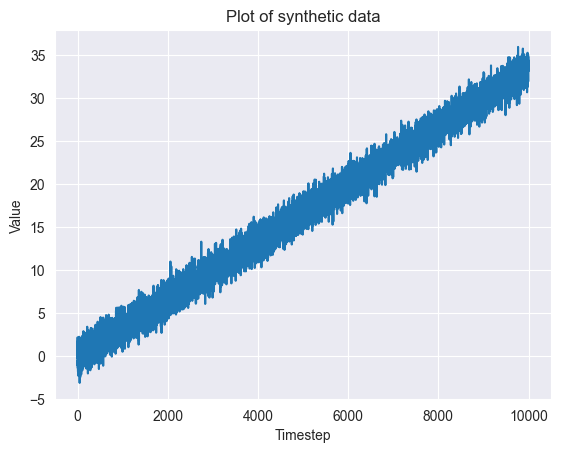

In [3]:
data = jnp.sin(jnp.arange(0, points)) * jnp.cos(jnp.arange(0, points)) + jnp.arange(0, points) * 1/300 + jax.random.normal(key=key, shape=(points,))
sns.lineplot(data)
plt.title("Plot of synthetic data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show();

In [4]:
from lstm import LSTM
from pprint import pprint

In [5]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=1, output_dim=1)


In [6]:
zero_arr = jnp.array([[0.]])

In [7]:
params.wf

Array([[-2.169826  ,  0.46480057]], dtype=float32)

In [8]:
jnp.concatenate([zero_arr, zero_arr], axis=1)

Array([[0., 0.]], dtype=float32)

In [9]:
LSTM.f_cur(params, zero_arr, zero_arr)

Array([[0.45395288]], dtype=float32)

In [10]:
LSTM.i_cur(params, zero_arr, zero_arr)

(Array([[0.45395288]], dtype=float32), Array([[-0.18263935]], dtype=float32))

In [11]:
LSTM.c_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.08290966]], dtype=float32)

In [12]:
LSTM.h_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.03755108]], dtype=float32)

In [13]:
LSTM.forward(params, zero_arr, zero_arr, zero_arr, zero_arr)

(Array([[-0.08290966]], dtype=float32),
 Array([[-0.]], dtype=float32),
 Array([[-0.03755108]], dtype=float32))

In [14]:
print(jnp.array([[0.]])[:,0])

[0.]


In [15]:
LSTM.forward_full(archi_params, params, jnp.array([[0.]]))

Array([[[0.00693613]]], dtype=float32)

In [16]:
def preprocess_ts(
    x: jnp.ndarray, 
    y: jnp.ndarray,
    timestep: int
) -> tuple[jnp.ndarray, jnp.ndarray]:
    x_window = np.lib.stride_tricks.sliding_window_view(
        x, window_shape=(timestep,), axis=0
    )
    y_window = np.lib.stride_tricks.sliding_window_view(
        y, window_shape=(timestep,), axis=0
    )

    x_window = jnp.expand_dims(jnp.array(x_window), axis=1)
    y_window = jnp.expand_dims(jnp.array(y_window), axis=2)
    return jnp.array(x_window), jnp.array(y_window)

In [17]:
x_window, y_window = preprocess_ts(np.arange(points).astype(np.float32), data, 5)

Each input will be a 2D array, with each 1D array inside it containing the time series for one variate.

In [18]:
x_window

Array([[[0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00]],

       [[1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00]],

       [[2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00]],

       ...,

       [[9.993e+03, 9.994e+03, 9.995e+03, 9.996e+03, 9.997e+03]],

       [[9.994e+03, 9.995e+03, 9.996e+03, 9.997e+03, 9.998e+03]],

       [[9.995e+03, 9.996e+03, 9.997e+03, 9.998e+03, 9.999e+03]]],      dtype=float32)

In [19]:
y_window

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]],

       [[-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ],
        [-1.3878875 ]],

       ...,

       [[31.921553  ],
        [34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ]],

       [[34.832302  ],
        [33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ]],

       [[33.669502  ],
        [34.03183   ],
        [34.385635  ],
        [33.160385  ],
        [33.882206  ]]], dtype=float32)

In [20]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=10, output_dim=1)

In [21]:
forward_full_batch = jax.vmap(LSTM.forward_full, in_axes=(None, 0))

In [22]:
x_window[0:2]

Array([[[0., 1., 2., 3., 4.]],

       [[1., 2., 3., 4., 5.]]], dtype=float32)

In [23]:
out = LSTM.forward_batch(archi_params, params, x_window[0:2])
out

Array([[[1.2368988],
        [2.0593126],
        [2.3274755],
        [2.2402394],
        [2.1290812]],

       [[1.6146609],
        [2.186683 ],
        [2.180825 ],
        [2.1135547],
        [2.098273 ]]], dtype=float32)

In [24]:
true = y_window[0:2]
true

Array([[[-0.25528347],
        [ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183]],

       [[ 2.2098098 ],
        [-1.075549  ],
        [-0.6162643 ],
        [-0.47484183],
        [-0.5634904 ]]], dtype=float32)

In [25]:
jnp.mean((out - true) ** 2)

Array(6.137471, dtype=float32)

In [52]:
num_epochs = 1
batch_size = 2
num_batches = x_window.shape[0] // batch_size
learning_rate = 1e-3

In [53]:
params.wo.shape

(10, 11)

In [54]:
LSTM.mse(archi_params, params, x_window[0:2], y_window[0:2])

Array(613.38983, dtype=float32)

In [70]:
mse_grad = jax.jacfwd(LSTM.mse, argnums=(1,))
mse_grad(archi_params, params, x_window[0:10], y_window[0:10])[0]

LSTMParams(wf=Array([[ 2.6919940e-01,  1.0599999e-01, -2.1812650e-03,  4.1278204e-01,
         4.2258751e-01, -9.4170170e-03, -3.1282149e-02, -2.3194347e-03,
        -1.9196916e-02, -1.3575364e-02,  1.3801091e+00],
       [-3.2267523e-01, -2.0644276e-01, -1.6290393e-02, -3.8544989e-01,
        -4.1574347e-01, -4.8446660e-03,  1.7217938e-02, -1.7137619e-02,
         5.6791883e-02,  5.4830864e-02, -1.5681478e+00],
       [-1.0893770e-03,  7.1343844e-04,  6.6197192e-04, -4.3670344e-03,
        -3.6341462e-03,  6.3525554e-04,  6.1178196e-04,  7.0705323e-04,
        -1.1819866e-03, -1.4811807e-03, -9.8986514e-03],
       [ 2.2558238e-02,  4.3059774e-03, -1.6175692e-03,  4.2246994e-02,
         4.1899830e-02, -2.6341861e-03, -4.0679271e-03, -1.7515258e-03,
         1.6914030e-03,  1.4369390e-03,  1.2426054e-01],
       [ 1.1554653e-02,  1.0458338e-03, -1.2359127e-03,  2.3655394e-02,
         2.3040159e-02, -1.7453072e-03, -2.4631058e-03, -1.3333103e-03,
         1.6863383e-03,  1.6371426e-03

In [56]:
optimiser = optax.adam(learning_rate=learning_rate)
opt_state = optimiser.init(params)

In [57]:
LSTM.mse(archi_params, params, x_window[0:10], y_window[0:10])

Array(638.1843, dtype=float32)

In [58]:
LSTM.mse(archi_params, params, x_window[100:101], y_window[100:101])

Array(650.9256, dtype=float32)

In [73]:
LSTM.backward(archi_params, params, x_window[0:1], y_window[0:1])

(LSTMParams(wf=Array([[ 1.10765123e+00,  1.29148871e-01, -1.61791556e-02,
          1.90423501e+00,  1.93201804e+00, -1.50973620e-02,
         -1.74414024e-01, -1.48470402e-02, -1.03052042e-01,
         -3.13042551e-02,  5.01823521e+00],
        [-5.58070302e-01, -5.30697405e-01, -1.71006501e-01,
         -7.32853264e-02, -2.65940636e-01, -1.66425690e-01,
         -6.84628114e-02, -1.83090121e-01,  3.95076662e-01,
          3.83986205e-01, -1.41833007e+00],
        [-1.17044514e-02,  6.92906231e-03,  6.62788143e-03,
         -4.50332090e-02, -3.77792083e-02,  6.44253520e-03,
          6.24054438e-03,  7.08296429e-03, -1.18388012e-02,
         -1.47091066e-02, -1.03266127e-01],
        [ 8.91206115e-02, -1.39470426e-02, -1.52546400e-02,
          2.12374359e-01,  1.99151710e-01, -1.47835398e-02,
         -2.44716853e-02, -1.61169041e-02,  1.92209650e-02,
          2.86220275e-02,  5.04497945e-01],
        [ 5.32803312e-02, -1.16124218e-02, -1.18654445e-02,
          1.37358189e-01,  1.2

In [74]:
LSTM.backward(archi_params, params, x_window[5:10], y_window[5:10])

(LSTMParams(wf=Array([[ 1.47022950e-02,  1.45124765e-02, -2.45300464e-11,
          1.50874741e-02,  1.51098501e-02, -7.94503285e-05,
         -4.08996420e-05, -5.46979059e-11, -9.10272414e-04,
         -2.78995467e-05,  1.33743271e-01],
        [-1.18767219e-02, -1.17091276e-02,  2.13809890e-11,
         -1.22077782e-02, -1.22272950e-02,  6.90911911e-05,
          3.54868316e-05,  4.77089028e-11,  7.67943508e-04,
          2.43899958e-05, -1.06761619e-01],
        [ 8.47609960e-13,  8.29384738e-13, -2.39274553e-21,
          8.80066473e-13,  8.82142395e-13, -6.95980630e-15,
         -3.67845868e-15, -5.39516761e-21, -6.79951904e-14,
         -2.66345466e-15,  6.94877966e-12],
        [ 3.02286411e-04,  2.97015446e-04, -6.75432420e-13,
          3.12123768e-04,  3.12728254e-04, -2.08911797e-06,
         -1.08383392e-06, -1.51652107e-12, -2.17147935e-05,
         -7.64670915e-07,  2.61010509e-03],
        [ 2.09882419e-05,  2.05723300e-05, -5.39907440e-14,
          2.17445977e-05,  2.1

In [75]:
params

LSTMParams(wf=Array([[-6.9480842e-01,  5.0934184e-01, -2.1541455e+00,  1.9844194e-01,
        -3.1637353e-01,  1.2398422e+00,  4.4910565e-01, -3.9422143e-02,
         1.8153216e-01,  8.1779844e-01,  6.6231602e-01],
       [ 1.2370384e-01,  1.1812255e+00, -3.2634370e+00, -7.5182229e-02,
        -4.2498943e-01, -4.6636161e-01,  1.8345567e+00, -1.3049967e-02,
        -8.4478974e-01,  7.5720596e-01,  7.3665774e-01],
       [ 6.7067188e-01,  7.9318172e-01, -6.1161780e-01,  3.2484613e-04,
         5.9757602e-01, -5.3828007e-01,  2.5188317e+00,  1.8418739e+00,
        -3.6460128e-02,  1.5391487e-01, -1.8273356e+00],
       [ 1.3063182e+00,  4.0587428e-01, -5.6782508e-01,  3.1954435e-01,
        -5.3829093e-02, -5.7919627e-01,  6.7278221e-02, -3.5324782e-01,
         9.1230255e-01, -1.8368726e+00,  1.0440072e+00],
       [ 6.1900133e-01,  6.0426109e-02,  4.3930283e-01,  9.4372720e-02,
         3.0290857e-03,  1.2807207e+00, -1.1917517e+00, -1.2513038e+00,
         8.0824322e-01,  2.1908423e-01

In [60]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")

    for i in range(num_batches):
        x_batch = x_window[i * batch_size : (i + 1) * batch_size]
        y_batch = y_window[i * batch_size : (i + 1) * batch_size]

        cur_grad = LSTM.backward(archi_params, params, x_batch, y_batch)[0]
        if (jnp.any(jnp.isnan(cur_grad.wf))):
            break
        updates, opt_state = optimiser.update(cur_grad, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        params = new_params

Epoch: 1


In [61]:
results = LSTM.forward_batch(archi_params, params, x_window)

In [62]:
results.shape

(9996, 5, 1)

In [63]:
params

LSTMParams(wf=Array([[-6.9480842e-01,  5.0934184e-01, -2.1541455e+00,  1.9844194e-01,
        -3.1637353e-01,  1.2398422e+00,  4.4910565e-01, -3.9422143e-02,
         1.8153216e-01,  8.1779844e-01,  6.6231602e-01],
       [ 1.2370384e-01,  1.1812255e+00, -3.2634370e+00, -7.5182229e-02,
        -4.2498943e-01, -4.6636161e-01,  1.8345567e+00, -1.3049967e-02,
        -8.4478974e-01,  7.5720596e-01,  7.3665774e-01],
       [ 6.7067188e-01,  7.9318172e-01, -6.1161780e-01,  3.2484613e-04,
         5.9757602e-01, -5.3828007e-01,  2.5188317e+00,  1.8418739e+00,
        -3.6460128e-02,  1.5391487e-01, -1.8273356e+00],
       [ 1.3063182e+00,  4.0587428e-01, -5.6782508e-01,  3.1954435e-01,
        -5.3829093e-02, -5.7919627e-01,  6.7278221e-02, -3.5324782e-01,
         9.1230255e-01, -1.8368726e+00,  1.0440072e+00],
       [ 6.1900133e-01,  6.0426109e-02,  4.3930283e-01,  9.4372720e-02,
         3.0290857e-03,  1.2807207e+00, -1.1917517e+00, -1.2513038e+00,
         8.0824322e-01,  2.1908423e-01

In [64]:
results[:,-1,-1]

Array([2.0348291, 2.0075977, 2.0116448, ..., 2.0359247, 2.0359247,
       2.0359247], dtype=float32)

<Axes: >

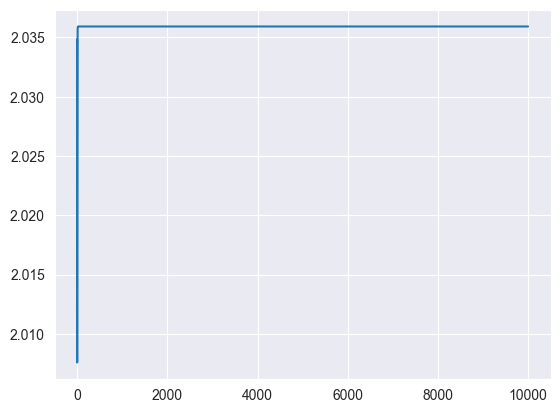

In [65]:
sns.lineplot(results[:,-1,-1])
